# Introduction

In this notebook, we aim to determine the IMGT positions of MHC molecules that make contact with the CDR loops of a contacting TCR. These contacts are then plotted based on the identity of the TCR loop to create a finger print of the TCRs on MHC molecules.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from python_pdb.parsers import parse_pdb_to_pandas

from tcr_pmhc_interface_analysis.imgt_numbering import assign_cdr_number

In [2]:
CUTOFF_DISTANCE = 5 # Å

In [3]:
STCRDAB_PATH = '../data/raw/stcrdab'

In [4]:
stcrdab_summary = pd.read_csv(os.path.join(STCRDAB_PATH, 'db_summary.dat'), delimiter='\t')

selected_stcrdab = stcrdab_summary.copy()

# Resolution better than 3.50 Å
selected_stcrdab['resolution'] = pd.to_numeric(selected_stcrdab['resolution'], errors='coerce')
selected_stcrdab = selected_stcrdab.query("resolution <= 3.50")

# alpha-beta TCRs
selected_stcrdab = selected_stcrdab.query("TCRtype == 'abTCR'")

# MHC class I
selected_stcrdab = selected_stcrdab.query("mhc_type == 'MH1'")

# peptide antigen
selected_stcrdab = selected_stcrdab.query("antigen_type == 'peptide'")

# General clean: drop columns that don't contain anything useful
selected_stcrdab = selected_stcrdab.loc[:, selected_stcrdab.nunique() > 1]
selected_stcrdab = selected_stcrdab.dropna(axis=1, how='all')

# Reset Index
selected_stcrdab = selected_stcrdab.reset_index(drop=True)

selected_stcrdab

,pdb,Bchain,Achain,antigen_chain,antigen_name,mhc_chain1,mhc_chain2,docking_angle,beta_subgroup,alpha_subgroup,...,alpha_organism,antigen_organism,mhc_chain1_organism,mhc_chain2_organism,authors,resolution,method,r_free,r_factor,engineered
0,8gom,E,D,C,spike protein s2,A,B,39.649,NaN,NaN,...,homo sapiens,severe acute respiratory syndrome coronavirus2,homo sapiens,homo sapiens,"Wu, D., Mariuzza, R.A.",2.783,X-RAY DIFFRACTION,0.248,0.195,True
1,8gon,E,D,C,spike protein s2,A,B,38.984,NaN,NaN,...,homo sapiens,severe acute respiratory syndrome coronavirus2,homo sapiens,homo sapiens,"Wu, D., Mariuzza, R.A.",2.601,X-RAY DIFFRACTION,0.253,0.198,True
2,7q99,E,D,C,asn-leu-ser-ala-leu-gly-ile-phe-ser-thr,A,B,46.371,TRBV30,TRAV12,...,homo sapiens,homo sapiens,homo sapiens,homo sapiens,"Rizkallah, P.J., Sewell, A.K., Wall, A., Fulle...",2.550,X-RAY DIFFRACTION,0.272,0.218,True
3,7q9a,E,D,C,leu-leu-leu-gly-ile-gly-ile-leu-val-leu,A,B,48.391,TRBV30,TRAV12,...,homo sapiens,homo sapiens,homo sapiens,homo sapiens,"Rizkallah, P.J., Sewell, A.K., Wall, A., Fulle...",2.100,X-RAY DIFFRACTION,0.243,0.205,True
4,2ak4,E,D,C,ebv peptide lpeplpqgqltay,A,B,71.108,TRBV6,TRAV19,...,homo sapiens,NaN,homo sapiens,homo sapiens,"Tynan, F.E., Burrows, S.R., Buckle, A.M., Clem...",2.500,X-RAY DIFFRACTION,0.278,0.246,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,6q3s,E,D,C,ser-leu-leu-met-trp-ile-thr-gln-val,A,B,67.059,TRBV6,TRAV21,...,homo sapiens,homo sapiens,homo sapiens,homo sapiens,"Meijers, R., Anjanappa, R., Springer, S., Garc...",2.500,X-RAY DIFFRACTION,0.273,0.229,True
298,5men,E,D,C,ile-leu-ala-lys-phe-leu-his-trp-leu,A,B,40.823,TRBV6,TRAV22,...,homo sapiens,homo sapiens,homo sapiens,homo sapiens,"Rizkallah, P.J., Lloyd, A., Crowther, M., Cole...",2.810,X-RAY DIFFRACTION,0.272,0.189,True
299,1ao7,E,D,C,tax peptide,A,B,34.827,TRBV6,TRAV12,...,homo sapiens,human t-lymphotropic virus 1,homo sapiens,homo sapiens,"Garboczi, D.N., Ghosh, P., Utz, U., Fan, Q.R.,...",2.600,X-RAY DIFFRACTION,0.320,0.245,True
300,4jff,E,D,C,melanoma motif,A,B,42.977,TRBV30,TRAV12,...,homo sapiens,homo sapiens,homo sapiens,homo sapiens,"Rizkallah, P.J., Cole, D.K., Madura, F., Sewel...",2.430,X-RAY DIFFRACTION,0.263,0.210,True


# Determine contacting residues

In [5]:
contacts = []

for _, row in selected_stcrdab.iterrows():
    path = os.path.join(STCRDAB_PATH, 'imgt', f'{row.pdb}.pdb')

    with open(path, 'r') as fh:
        df = parse_pdb_to_pandas(fh.read())

    chain_annotations = {}
    chain_annotations[row.Achain] = 'alpha_chain'
    chain_annotations[row.Bchain] = 'beta_chain'
    chain_annotations[row.antigen_chain] = 'antigen_chain'
    chain_annotations[row.mhc_chain1] = 'mhc_chain'

    df['chain_type'] = df['chain_id'].map(lambda id_: chain_annotations[id_] if id_ in chain_annotations else None)
    df['cdr'] = df['residue_seq_id'].map(assign_cdr_number)

    mhc_df = df.query("chain_type == 'mhc_chain' and residue_seq_id < 1090")
    peptide_df = df.query("chain_type == 'antigen_chain'").copy()
    tcr_cdrs_df = df.query("(chain_type == 'alpha_chain' or chain_type == 'beta_chain') and cdr.notnull()")

    peptide_df_per_res = peptide_df.groupby(['residue_seq_id', 'residue_insert_code', 'residue_name'], dropna=False)
    group_mapping = {group: idx for idx, group in enumerate(peptide_df_per_res.groups.keys(), 1)}

    peptide_df['peptide_length'] = max(group_mapping.values())
    peptide_df['peptide_position'] = peptide_df[['residue_seq_id',
                                                 'residue_insert_code',
                                                 'residue_name']].apply(tuple, axis='columns').map(group_mapping)

    tcr_mhc_interface = tcr_cdrs_df.merge(mhc_df, how='cross', suffixes=('_tcr', '_mhc'))
    tcr_mhc_interface['distance'] = np.sqrt(np.square(tcr_mhc_interface['pos_x_tcr']
                                                       - tcr_mhc_interface['pos_x_mhc'])
                                             + np.square(tcr_mhc_interface['pos_y_tcr']
                                                         - tcr_mhc_interface['pos_y_mhc'])
                                             + np.square(tcr_mhc_interface['pos_z_tcr']
                                                         - tcr_mhc_interface['pos_z_mhc']))

    tcr_peptide_interface = tcr_cdrs_df.merge(peptide_df, how='cross', suffixes=('_tcr', '_peptide'))
    tcr_peptide_interface['distance'] = np.sqrt(np.square(tcr_peptide_interface['pos_x_tcr']
                                                          - tcr_peptide_interface['pos_x_peptide'])
                                                + np.square(tcr_peptide_interface['pos_y_tcr']
                                                            - tcr_peptide_interface['pos_y_peptide'])
                                                + np.square(tcr_peptide_interface['pos_z_tcr']
                                                            - tcr_peptide_interface['pos_z_peptide']))

    contacts_tcr_mhc = tcr_mhc_interface.query('distance < @CUTOFF_DISTANCE').copy()
    contacts_tcr_mhc['path'] = path
    contacts_tcr_mhc['interface_type'] = 'tcr_mhc'
    contacts.append(contacts_tcr_mhc)

    contacts_tcr_peptide = tcr_peptide_interface.query('distance < @CUTOFF_DISTANCE').copy()
    contacts_tcr_peptide['path'] = path
    contacts_tcr_peptide['interface_type'] = 'tcr_peptide'
    contacts.append(contacts_tcr_peptide)

contacts = pd.concat(contacts)
contacts

,record_type_tcr,atom_number_tcr,atom_name_tcr,alt_loc_tcr,residue_name_tcr,chain_id_tcr,residue_seq_id_tcr,residue_insert_code_tcr,pos_x_tcr,pos_y_tcr,...,pos_y_peptide,pos_z_peptide,occupancy_peptide,b_factor_peptide,element_peptide,charge_peptide,chain_type_peptide,cdr_peptide,peptide_length,peptide_position
69473,ATOM,472,C,None,ASN,E,57,None,12.312,-60.161,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69474,ATOM,472,C,None,ASN,E,57,None,12.312,-60.161,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70937,ATOM,473,O,None,ASN,E,57,None,11.507,-60.966,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70938,ATOM,473,O,None,ASN,E,57,None,11.507,-60.966,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70939,ATOM,473,O,None,ASN,E,57,None,11.507,-60.966,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31515,ATOM,10078,CD2,None,TYR,N,113,None,-51.375,74.966,...,73.846,-3.678,1.0,63.86,O,None,antigen_chain,NaN,10.0,4.0
31516,ATOM,10078,CD2,None,TYR,N,113,None,-51.375,74.966,...,75.095,-6.148,1.0,63.91,C,None,antigen_chain,NaN,10.0,4.0
31517,ATOM,10078,CD2,None,TYR,N,113,None,-51.375,74.966,...,76.511,-6.671,1.0,63.85,C,None,antigen_chain,NaN,10.0,4.0
31697,ATOM,10080,CE2,None,TYR,N,113,None,-52.313,73.948,...,73.846,-3.678,1.0,63.86,O,None,antigen_chain,NaN,10.0,4.0


In [6]:
contacts['pdb_id'] = contacts['path'].map(lambda path: path.split('/')[-1].split('.')[0])

In [7]:
def create_resi(seq_id: float, insert_code: str | float) -> str | None:
    if pd.isnull(seq_id):
        return None

    return str(int(seq_id)) + (insert_code if not pd.isnull(insert_code) else '')

contacts['resi_mhc'] = contacts.apply(lambda row: create_resi(row.residue_seq_id_mhc, row.residue_insert_code_mhc),
                                      axis='columns')
contacts['resi_tcr'] = contacts.apply(lambda row: create_resi(row.residue_seq_id_tcr, row.residue_insert_code_tcr),
                                      axis='columns')

In [8]:
contacts.loc[contacts['peptide_position'].notnull(),
             'peptide_position'] = contacts.loc[contacts['peptide_position'].notnull(),
                                                'peptide_position'].apply(int).apply(str)

In [9]:
contacts['cdr_name'] = contacts.apply(
    lambda row: f"CDR-{'A' if row.chain_type_tcr == 'alpha_chain' else 'B'}{int(row.cdr_tcr)}",
    axis='columns',
)

# Visualise contact maps

In [10]:
palette = sns.color_palette(['#' + colour.lower()
                             for colour in ['DC91BE','C0C0C2', '6490C7', '963E87','2D2E62','56BBD3']],
                            6)

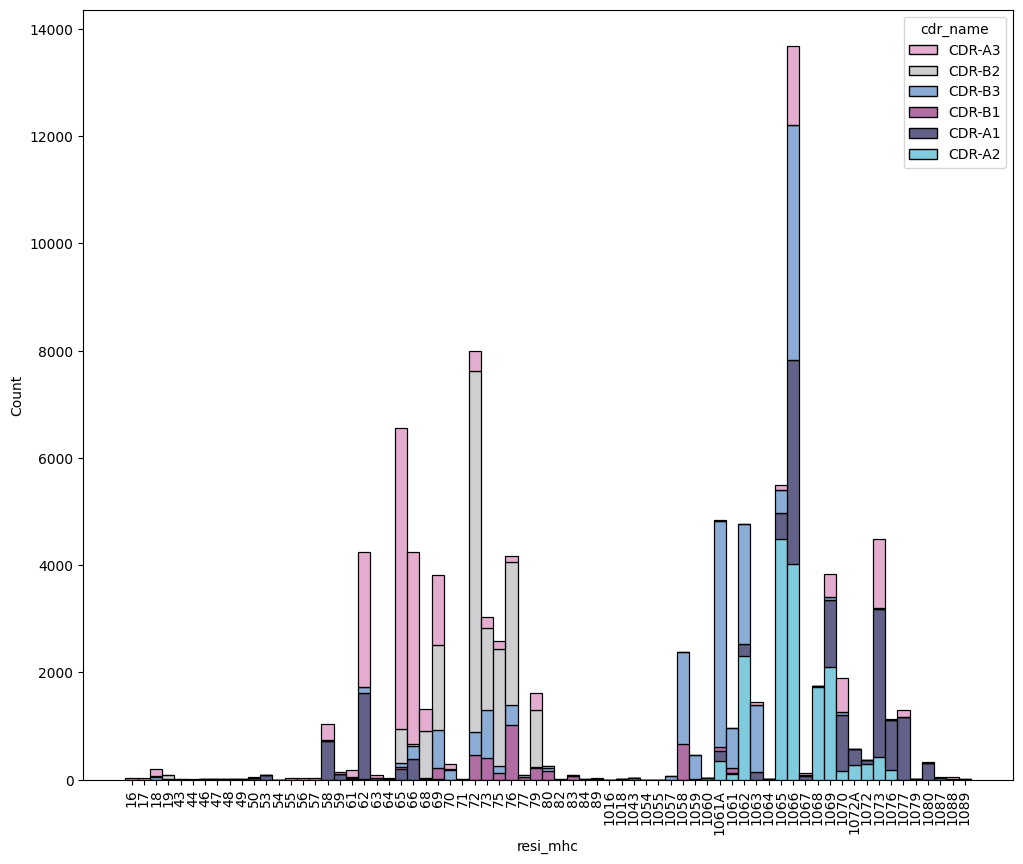

In [11]:
plt.figure(figsize=(12, 10))

sns.histplot(contacts.query("interface_type == 'tcr_mhc'").sort_values('residue_seq_id_mhc'),
             x='resi_mhc', hue='cdr_name', multiple='stack', palette=palette)
plt.xticks(rotation=90)

plt.show()

In [12]:
mhc_labels = contacts[
    ['residue_seq_id_mhc', 'residue_insert_code_mhc', 'resi_mhc']
].fillna('').sort_values(['residue_seq_id_mhc', 'residue_insert_code_mhc'])['resi_mhc'].unique().tolist()

tcr_labels = contacts[
    ['residue_seq_id_tcr', 'residue_insert_code_tcr', 'resi_tcr']
    ].fillna('').sort_values(['residue_seq_id_tcr', 'residue_insert_code_tcr'])['resi_tcr'].unique().tolist()

contacts['resi_mhc'] = pd.Categorical(contacts['resi_mhc'], mhc_labels)
contacts['resi_tcr'] = pd.Categorical(contacts['resi_tcr'], tcr_labels)

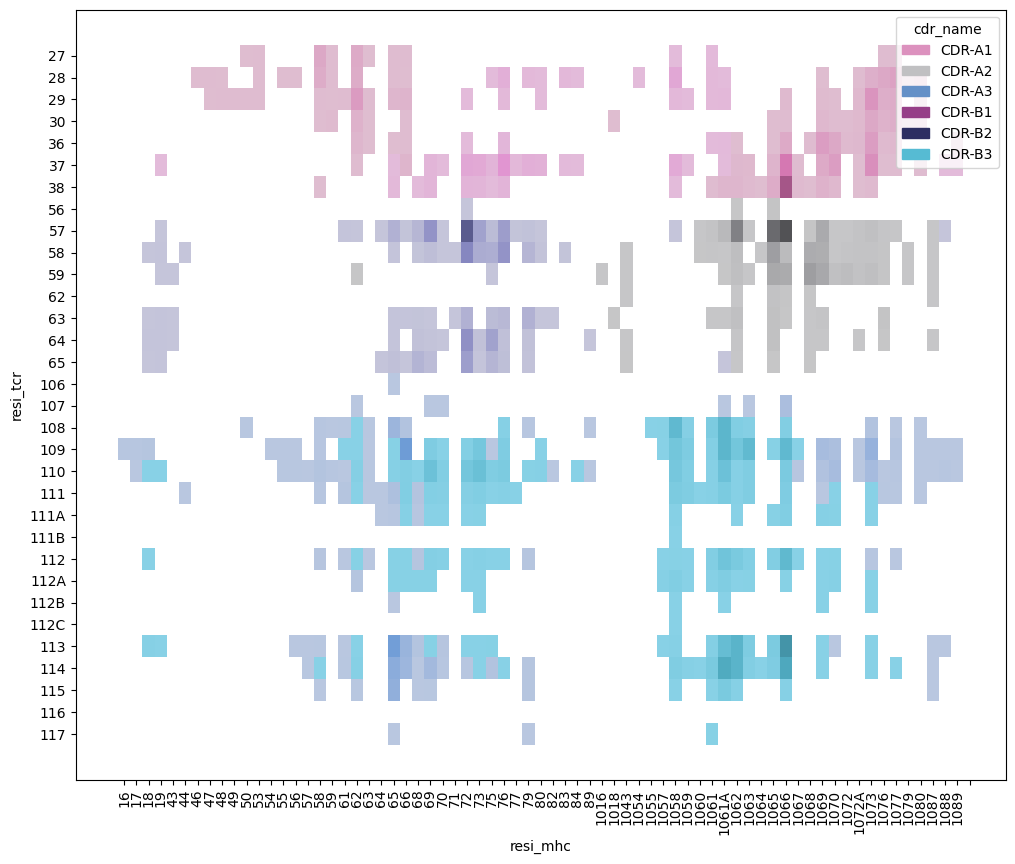

In [13]:
contacts['cdr_name'] = pd.Categorical(contacts['cdr_name'],
                                      ['CDR-A1', 'CDR-A2', 'CDR-A3', 'CDR-B1', 'CDR-B2', 'CDR-B3'])
plt.figure(figsize=(12, 10))

sns.histplot(contacts.query("interface_type == 'tcr_mhc'"),
             x='resi_mhc', y='resi_tcr',
             hue='cdr_name',
             palette=sns.color_palette(palette, 6))
plt.xticks(rotation=90)

plt.show()

<AxesSubplot: xlabel='peptide_length', ylabel='Count'>

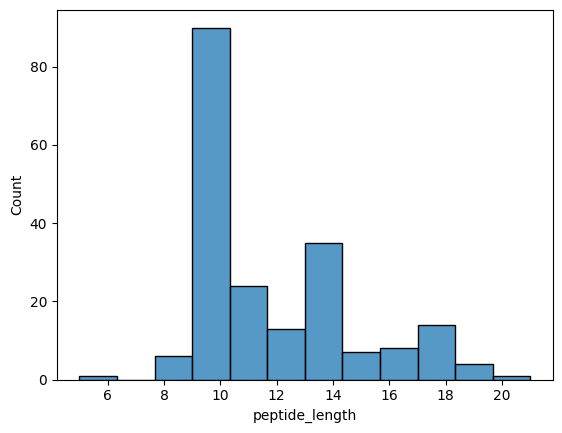

In [14]:
sns.histplot(contacts.query("interface_type == 'tcr_peptide'").drop_duplicates('path'), x='peptide_length')

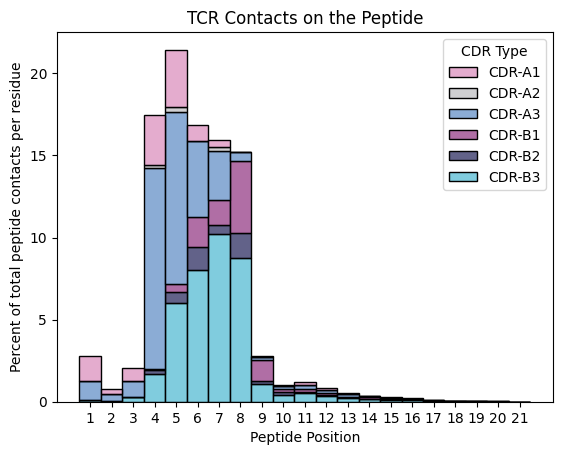

In [15]:
ax = sns.histplot(contacts.query("interface_type == 'tcr_peptide'").sort_values('residue_seq_id_peptide'),
                  x='peptide_position',
                  hue='cdr_name',
                  multiple='stack',
                  stat='percent',
                  palette=sns.color_palette(palette, 6))

ax.set_title('TCR Contacts on the Peptide')
ax.set_xlabel('Peptide Position')
ax.set_ylabel('Percent of total peptide contacts per residue')
ax.legend_.set_title(title='CDR Type')

plt.savefig('../report/figures/peptide_contacts_by_cdr_loop.svg')
plt.show()

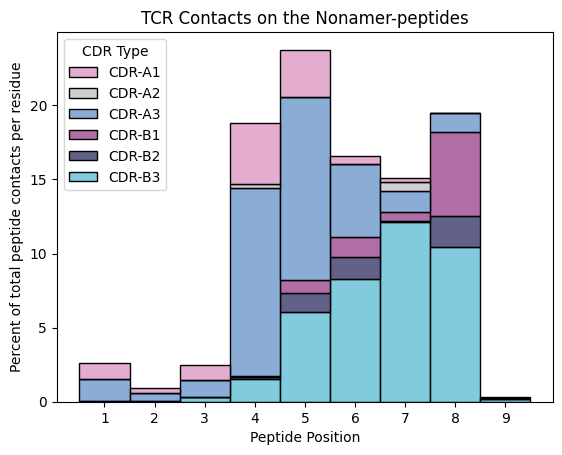

In [16]:
ax = sns.histplot(contacts.query("interface_type == 'tcr_peptide' and peptide_length == 9.0").sort_values('residue_seq_id_peptide'),
                  x='peptide_position',
                  hue='cdr_name',
                  multiple='stack',
                  stat='percent',
                  palette=sns.color_palette(palette, 6))

ax.set_title('TCR Contacts on the Nonamer-peptides')
ax.set_xlabel('Peptide Position')
ax.set_ylabel('Percent of total peptide contacts per residue')
ax.legend_.set_title(title='CDR Type')

plt.savefig('../report/figures/nonamer_peptide_contacts_by_cdr_loop.svg')
plt.show()

In [17]:
def select_dominant(group: pd.DataFrame) -> str:
    return group.sort_values('count', ascending=False).iloc[0]['cdr_name']

nonanmer_peptide_tcr_contact_counts = (contacts.query("interface_type == 'tcr_peptide' and peptide_length == 9.0")
                                               .value_counts(['peptide_position', 'cdr_name']))
nonanmer_peptide_tcr_contact_counts.name = 'count'
nonanmer_peptide_tcr_contact_counts = nonanmer_peptide_tcr_contact_counts.reset_index()

nonanmer_peptide_tcr_contact_counts.groupby('peptide_position').apply(select_dominant)

peptide_position
1    CDR-A3
2    CDR-A3
3    CDR-A3
4    CDR-A3
5    CDR-A3
6    CDR-B3
7    CDR-B3
8    CDR-B3
9    CDR-B3
dtype: object

# Export residue list

In [18]:
contact_positions = contacts.value_counts(['cdr_name', 'resi_mhc'])
contact_positions.name = 'count'
contact_positions = contact_positions.to_frame().reset_index().sort_values('resi_mhc')

contact_positions.to_csv('../data/processed/mhc_contacts.csv', index=False)